From https://shiring.github.io/machine_learning/2017/03/31/webinar_code

The dataset
The dataset I am using in these example analyses, is the Breast Cancer Wisconsin (Diagnostic) Dataset. The data was downloaded from the UC Irvine Machine Learning Repository.

The first dataset looks at the predictor classes:

malignant or
benign breast mass.
The features characterize cell nucleus properties and were generated from image analysis of fine needle aspirates (FNA) of breast masses:

Sample ID (code number)
Clump thickness
Uniformity of cell size
Uniformity of cell shape
Marginal adhesion
Single epithelial cell size
Number of bare nuclei
Bland chromatin
Number of normal nuclei
Mitosis
Classes, i.e. diagnosis

In [1]:
#system('wget "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"', intern=TRUE)

In [2]:
bc_data <- read.table("breast-cancer-wisconsin.data", 
                      header = FALSE, 
                      sep = ",")

In [3]:
head(bc_data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
1017122,8,10,10,8,7,10,9,7,1,4


In [4]:
colnames(bc_data) <- c("sample_code_number", 
                       "clump_thickness", 
                       "uniformity_of_cell_size", 
                       "uniformity_of_cell_shape", 
                       "marginal_adhesion", 
                       "single_epithelial_cell_size", 
                       "bare_nuclei", 
                       "bland_chromatin", 
                       "normal_nucleoli", 
                       "mitosis", 
                       "classes")

In [5]:
bc_data$classes <- ifelse(bc_data$classes == "2", "benign",
                          ifelse(bc_data$classes == "4", "malignant", NA))

Missing data

In [6]:
bc_data[bc_data == "?"] <- NA

# how many NAs are in the data
length(which(is.na(bc_data)))

[1] 16

In [7]:
# how many samples would we lose, if we removed them?
nrow(bc_data)

[1] 699

In [8]:
nrow(bc_data[is.na(bc_data), ])

[1] 16

In [9]:
#install.packages('mice')

Missing values are imputed with the mice package.

In [10]:
# impute missing data
library(mice)

bc_data[,2:10] <- apply(bc_data[, 2:10], 2, function(x) as.numeric(as.character(x)))
dataset_impute <- mice(bc_data[, 2:10],  print = FALSE)
bc_data <- cbind(bc_data[, 11, drop = FALSE], mice::complete(dataset_impute, 1))

bc_data$classes <- as.factor(bc_data$classes)

# how many benign and malignant cases are there?
summary(bc_data$classes)

Loading required package: lattice


benign malignant 
      458       241

Data exploration
Response variable for classification

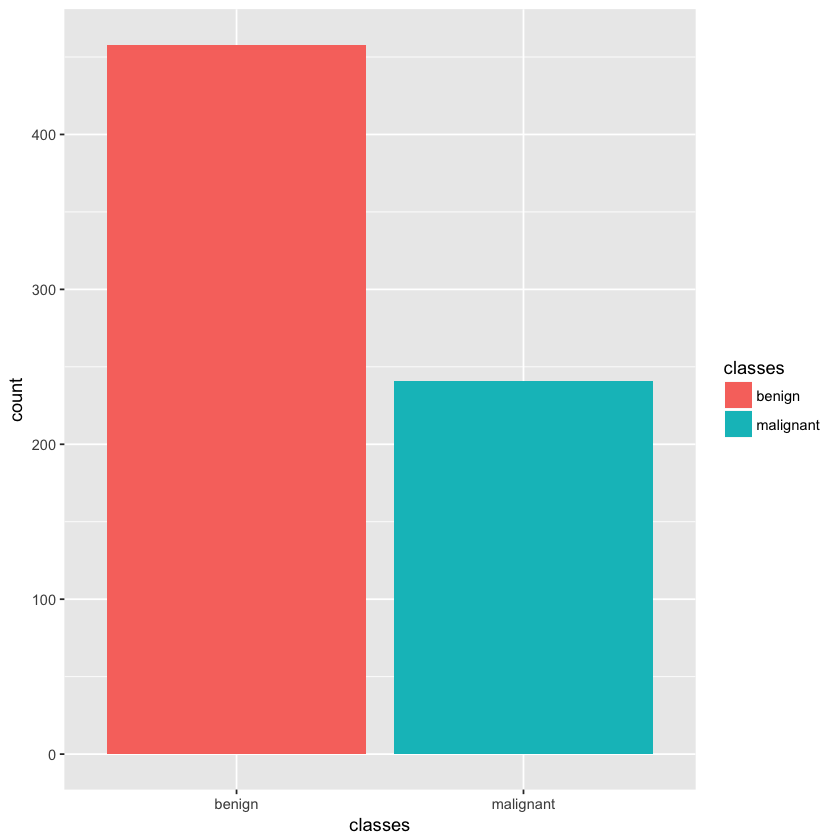

In [11]:
library(ggplot2)

ggplot(bc_data, aes(x = classes, fill = classes)) +
  geom_bar()

We can see that our data is unbalanced. For simplicity’s sake, I am not going to go into how to deal with this, here. But I added a short post about dealing with unbalanced datasets using caret for you to check out.



Response variable for regression

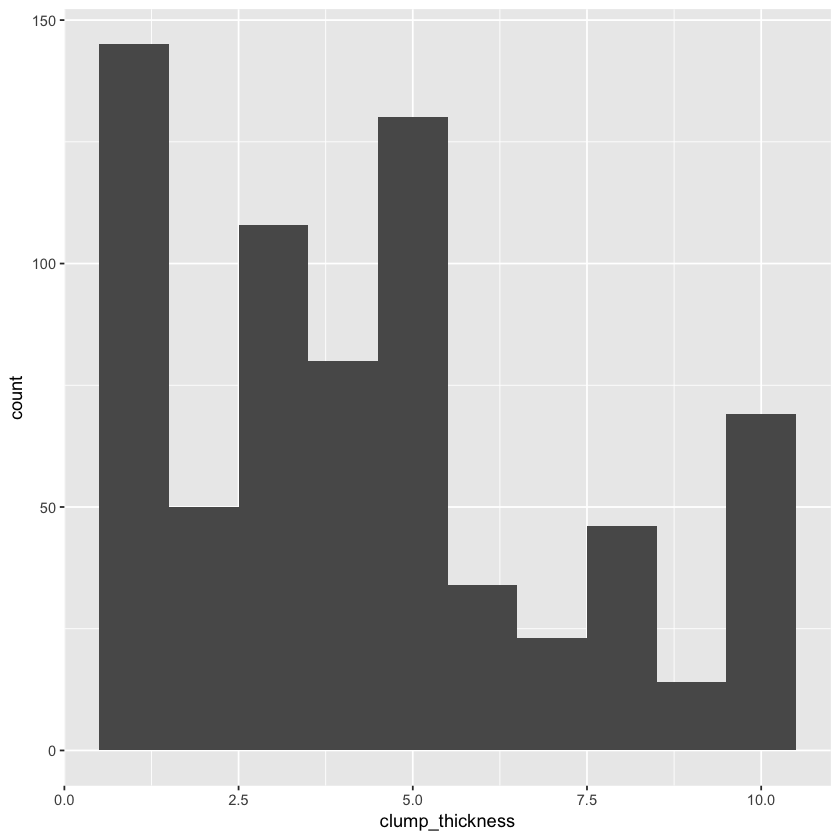

In [12]:
ggplot(bc_data, aes(x = clump_thickness)) +
  geom_histogram(bins = 10)

In [13]:
#source("https://bioconductor.org/biocLite.R")
#biocLite("pcaGoPromoter")

Principal Component Analysis

Loading required package: ellipse

Attaching package: ‘ellipse’

The following object is masked from ‘package:graphics’:

    pairs

Loading required package: Biostrings
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, set

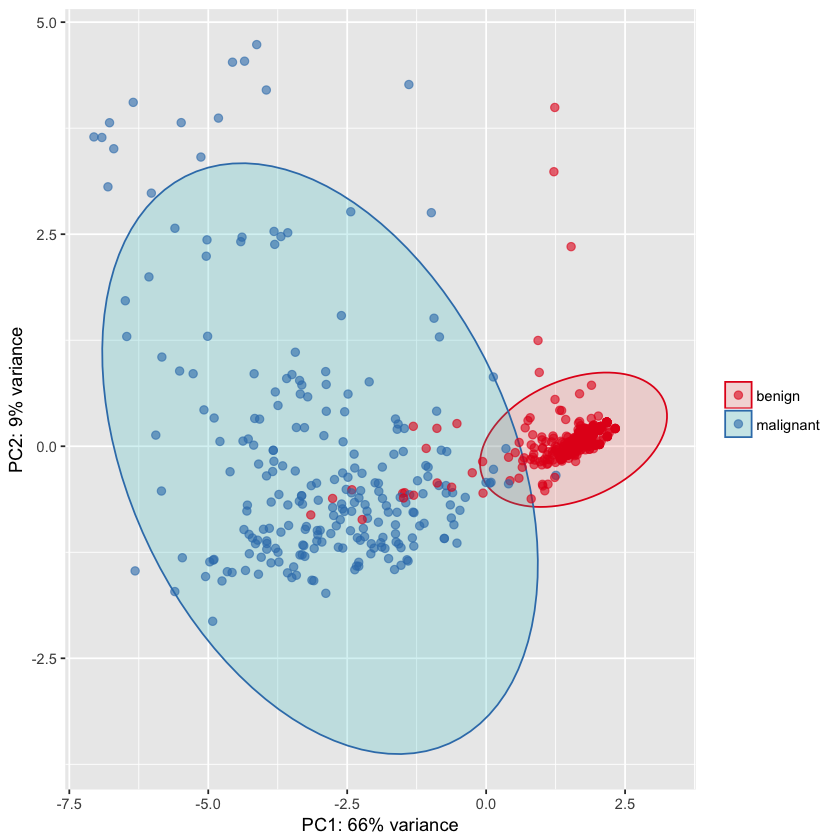

In [14]:
library(pcaGoPromoter)
library(ellipse)

# perform pca and extract scores
pcaOutput <- pca(t(bc_data[, -1]), printDropped = FALSE, scale = TRUE, center = TRUE)
pcaOutput2 <- as.data.frame(pcaOutput$scores)
  
# define groups for plotting
pcaOutput2$groups <- bc_data$classes
  
centroids <- aggregate(cbind(PC1, PC2) ~ groups, pcaOutput2, mean)

conf.rgn  <- do.call(rbind, lapply(unique(pcaOutput2$groups), function(t)
  data.frame(groups = as.character(t),
             ellipse(cov(pcaOutput2[pcaOutput2$groups == t, 1:2]),
                   centre = as.matrix(centroids[centroids$groups == t, 2:3]),
                   level = 0.95),
             stringsAsFactors = FALSE)))
    
ggplot(data = pcaOutput2, aes(x = PC1, y = PC2, group = groups, color = groups)) + 
    geom_polygon(data = conf.rgn, aes(fill = groups), alpha = 0.2) +
    geom_point(size = 2, alpha = 0.6) + 
    scale_color_brewer(palette = "Set1") +
    labs(color = "",
         fill = "",
         x = paste0("PC1: ", round(pcaOutput$pov[1], digits = 2) * 100, "% variance"),
         y = paste0("PC2: ", round(pcaOutput$pov[2], digits = 2) * 100, "% variance")) 

In [15]:
#install.packages('tidyr')

Features


Attaching package: ‘tidyr’

The following object is masked from ‘package:S4Vectors’:

    expand

The following object is masked from ‘package:mice’:

    complete



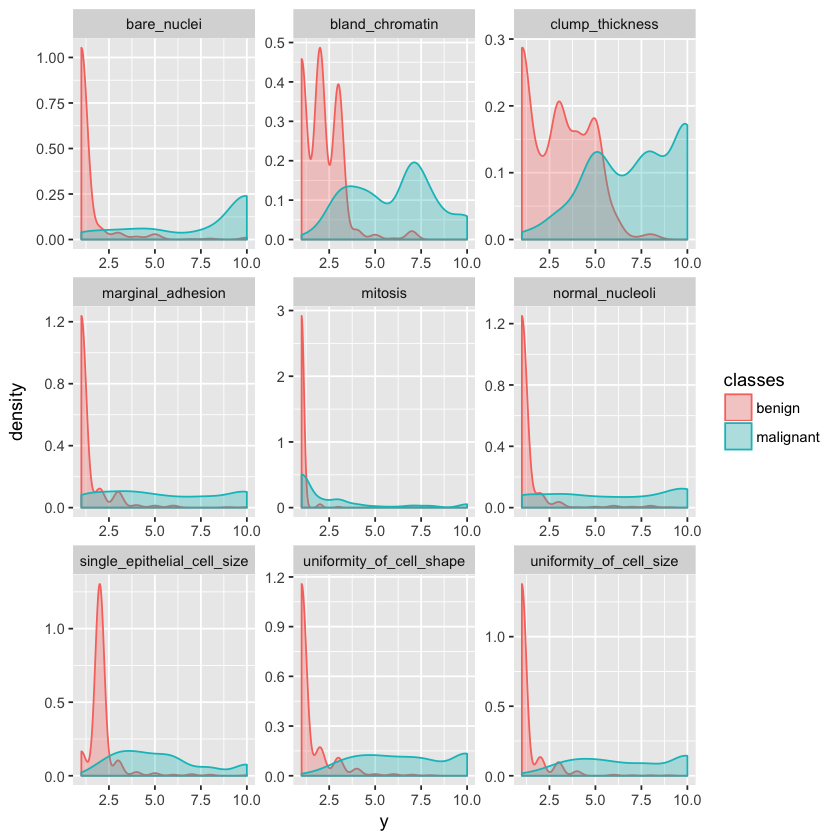

In [16]:
library(tidyr)

gather(bc_data, x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = classes, fill = classes)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

In [17]:
#install.packages('doParallel')

In [18]:
#install.packages('caret')

Machine Learning packages for R

caret

In [19]:
# configure multicore
library(doParallel)
cl <- makeCluster(detectCores())
registerDoParallel(cl)

library(caret)

Loading required package: foreach
Loading required package: iterators


Training, validation and test data

In [20]:
set.seed(42)
index <- createDataPartition(bc_data$classes, p = 0.7, list = FALSE)
train_data <- bc_data[index, ]
test_data  <- bc_data[-index, ]


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union

The following object is masked from ‘package:XVector’:

    slice

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



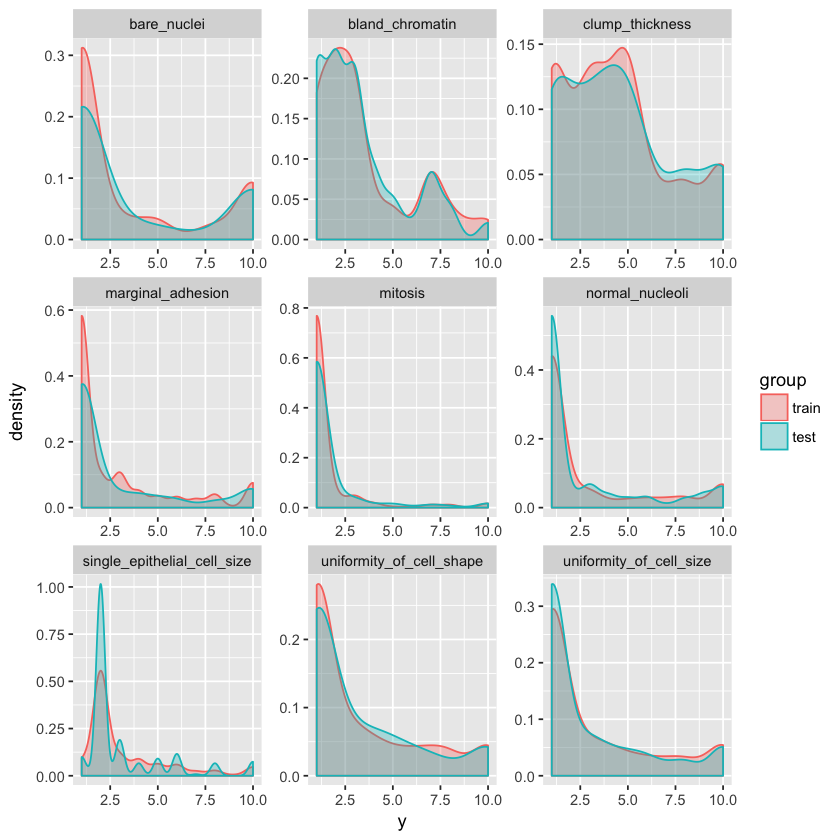

In [21]:
library(dplyr)

rbind(data.frame(group = "train", train_data),
      data.frame(group = "test", test_data)) %>%
  gather(x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = group, fill = group)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

Regression

In [22]:
set.seed(42)
model_glm <- caret::train(clump_thickness ~ .,
                          data = train_data,
                          method = "glm",
                          preProcess = c("scale", "center"),
                          trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

In [23]:
model_glm

Generalized Linear Model 

490 samples
  9 predictor

Pre-processing: scaled (9), centered (9) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 440, 440, 441, 441, 442, 441, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.977337  0.5024109  1.638512


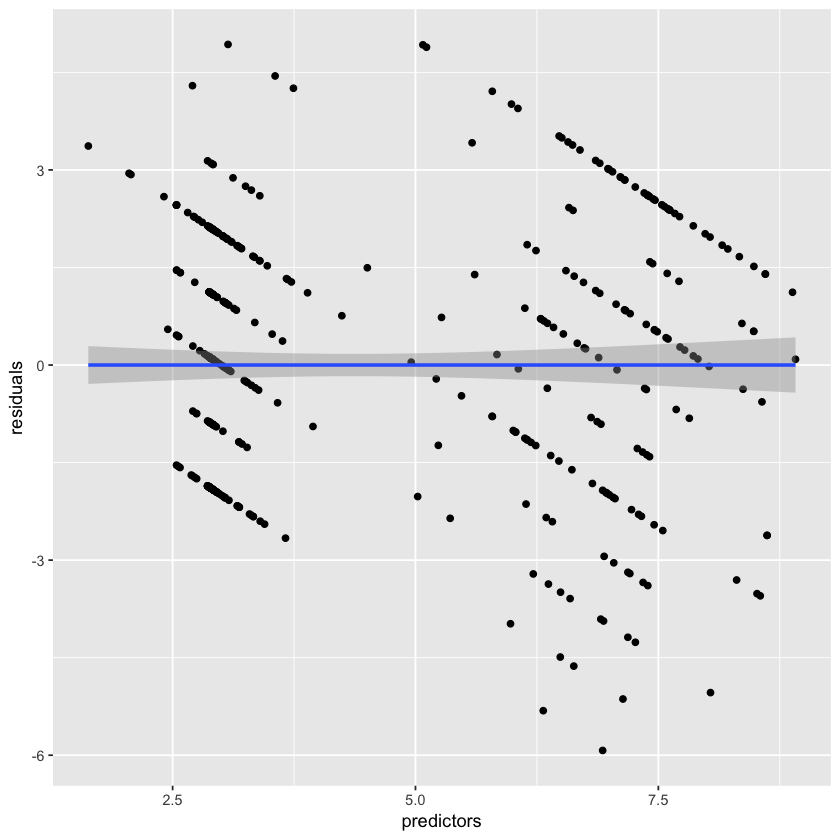

In [24]:
predictions <- predict(model_glm, test_data)# model_glm$finalModel$linear.predictors == model_glm$finalModel$fitted.values
data.frame(residuals = resid(model_glm),
           predictors = model_glm$finalModel$linear.predictors) %>%
  ggplot(aes(x = predictors, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

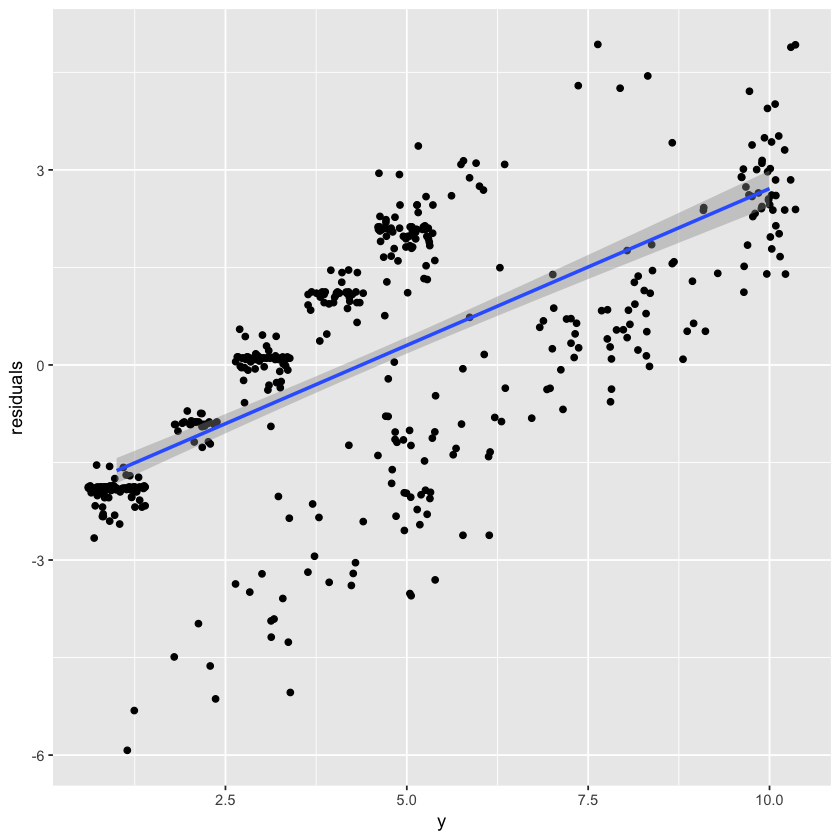

In [25]:
# y == train_data$clump_thickness
data.frame(residuals = resid(model_glm),
           y = model_glm$finalModel$y) %>%
  ggplot(aes(x = y, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

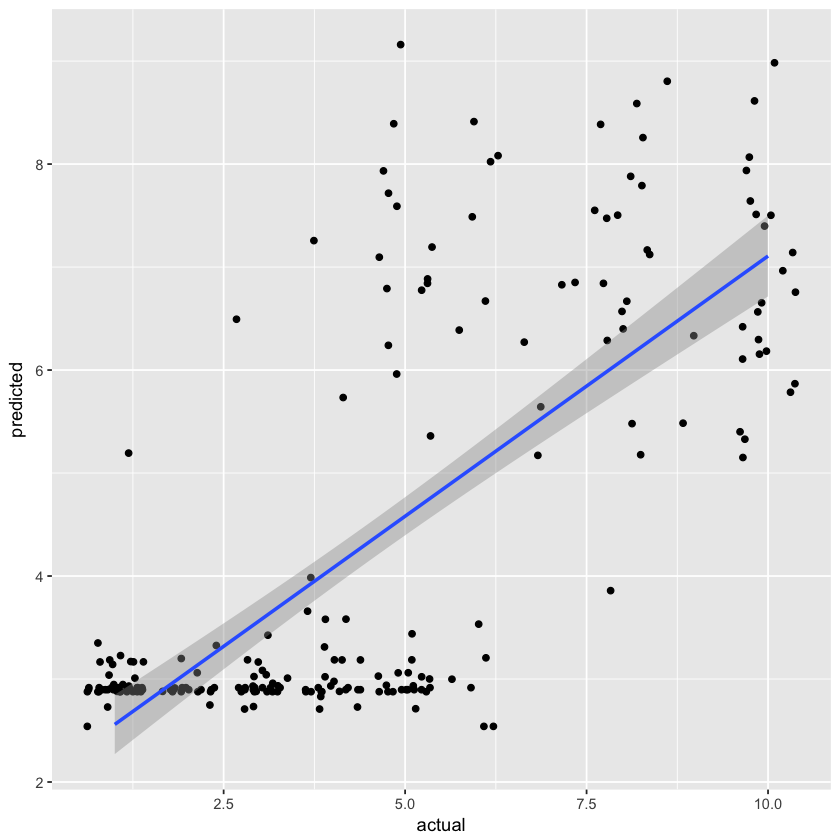

In [26]:
data.frame(actual = test_data$clump_thickness,
           predicted = predictions) %>%
  ggplot(aes(x = actual, y = predicted)) +
    geom_jitter() +
    geom_smooth(method = "lm")

In [27]:
#install.packages("rpart")
#install.packages("rpart.plot")

Classification

Decision trees

rpart

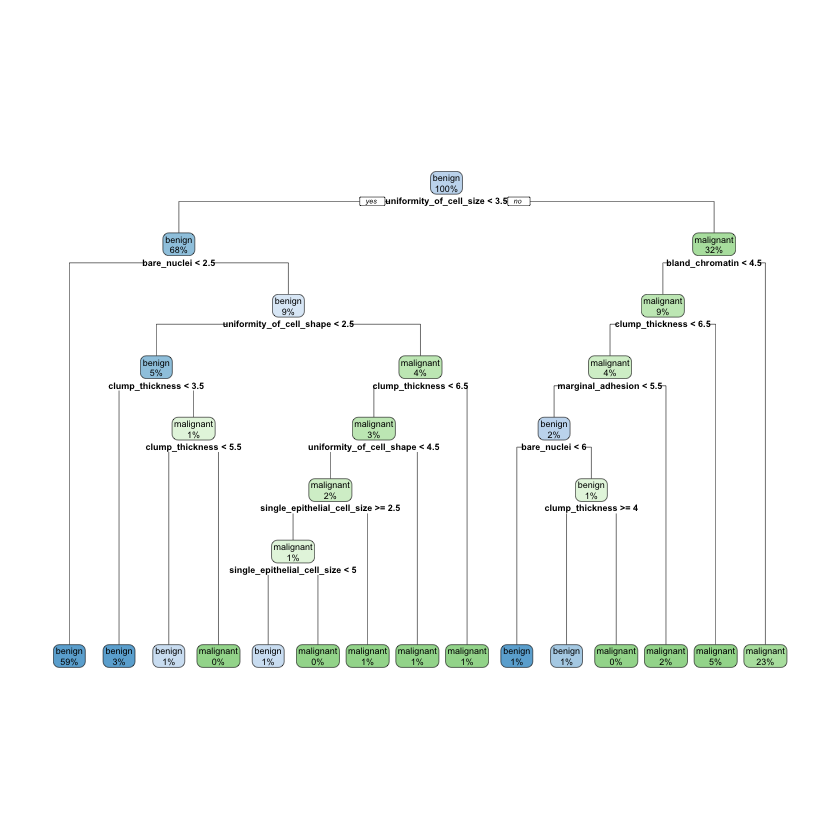

In [28]:
library(rpart)
library(rpart.plot)

set.seed(42)
fit <- rpart(classes ~ .,
            data = train_data,
            method = "class",
            control = rpart.control(xval = 10, 
                                    minbucket = 2, 
                                    cp = 0), 
             parms = list(split = "information"))

rpart.plot(fit, extra = 100)

In [29]:
#install.packages("randomForest")
#install.packages("e1071")

Random Forests

Random Forests predictions are based on the generation of multiple classification trees. They can be used for both, classification and regression tasks. Here, I show a classification task.

In [30]:
set.seed(42)
model_rf <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

When you specify savePredictions = TRUE, you can access the cross-validation resuls with model_rf$pred.

In [31]:
model_rf$finalModel$confusion

,benign,malignant,class.error
benign,312,9,0.02803738
malignant,5,164,0.02958580


Feature Importance

In [32]:
imp <- model_rf$finalModel$importance
imp[order(imp, decreasing = TRUE), ]

uniformity_of_cell_size    uniformity_of_cell_shape 
                  54.073531                   37.937980 
                bare_nuclei             bland_chromatin 
                  32.682588                   25.368815 
single_epithelial_cell_size             normal_nucleoli 
                  21.187432                   18.575111 
            clump_thickness           marginal_adhesion 
                  15.376042                   11.636250 
                    mitosis 
                   2.785588

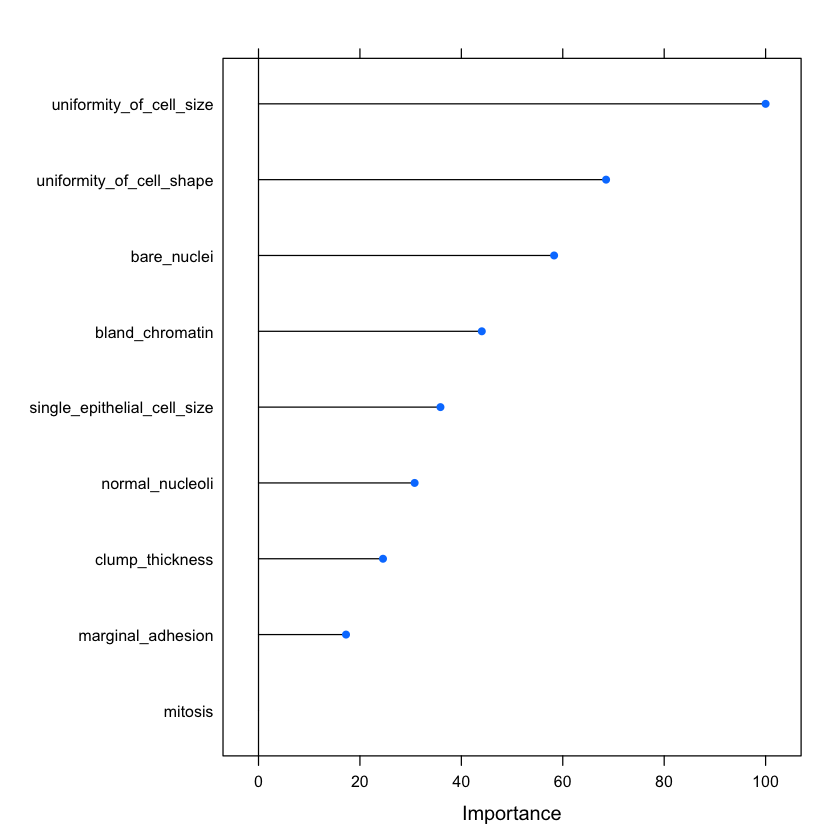

In [33]:
# estimate variable importance
importance <- varImp(model_rf, scale = TRUE)
plot(importance)

predicting test data

In [34]:
confusionMatrix(predict(model_rf, test_data), test_data$classes)

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       133         2
  malignant      4        70
                                          
               Accuracy : 0.9713          
                 95% CI : (0.9386, 0.9894)
    No Information Rate : 0.6555          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9369          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9708          
            Specificity : 0.9722          
         Pos Pred Value : 0.9852          
         Neg Pred Value : 0.9459          
             Prevalence : 0.6555          
         Detection Rate : 0.6364          
   Detection Prevalence : 0.6459          
      Balanced Accuracy : 0.9715          
                                          
       'Positive' Class : benign          
                                          

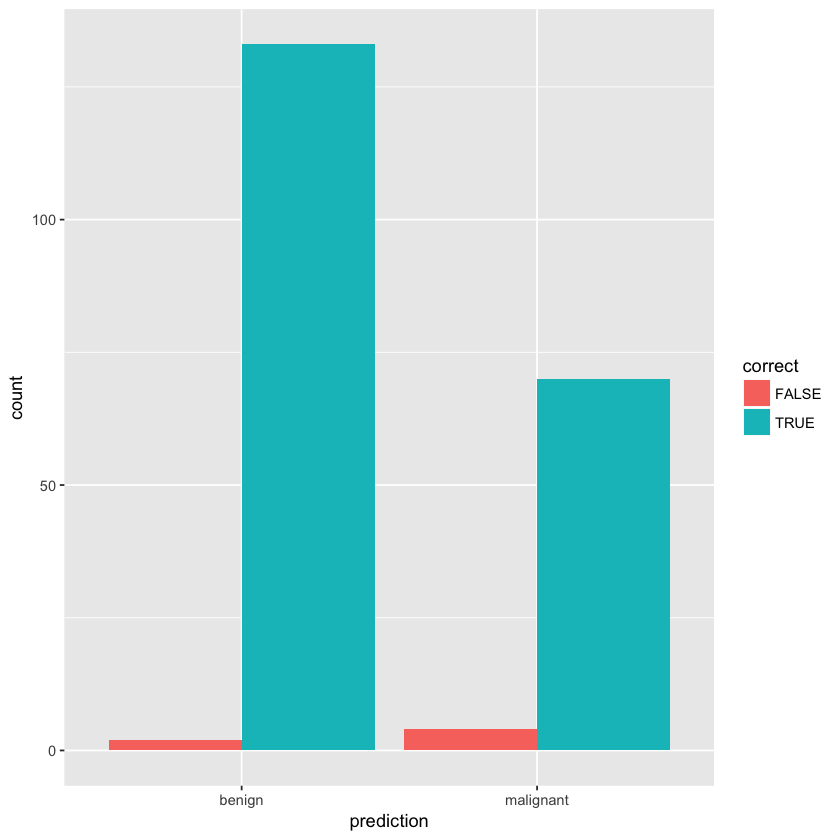

In [35]:
results <- data.frame(actual = test_data$classes,
                      predict(model_rf, test_data, type = "prob"))

results$prediction <- ifelse(results$benign > 0.5, "benign",
                             ifelse(results$malignant > 0.5, "malignant", NA))

results$correct <- ifelse(results$actual == results$prediction, TRUE, FALSE)

ggplot(results, aes(x = prediction, fill = correct)) +
  geom_bar(position = "dodge")

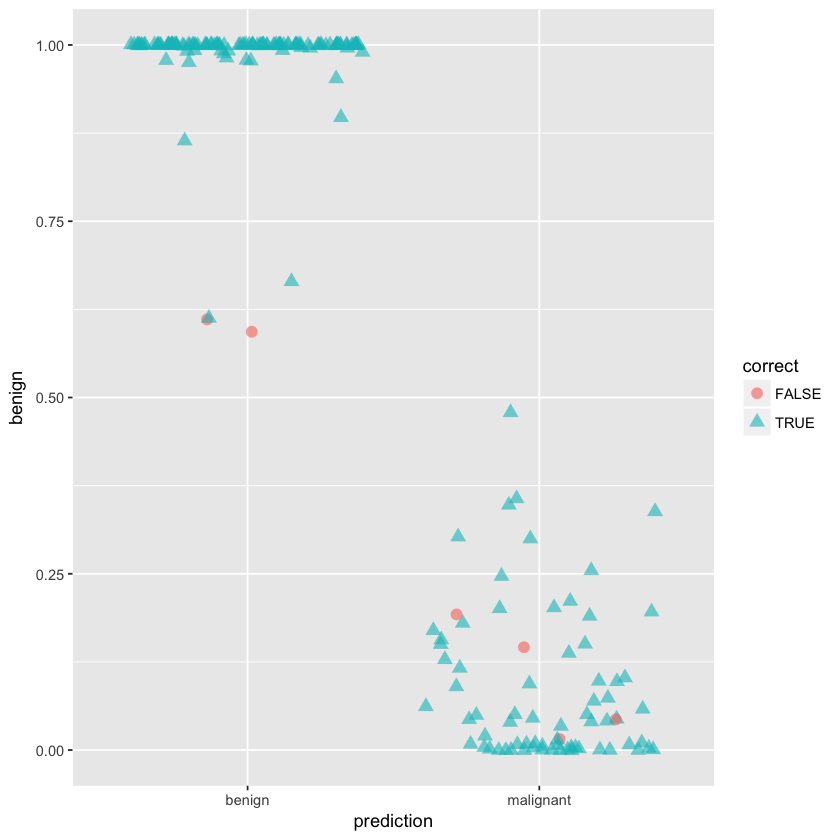

In [36]:
ggplot(results, aes(x = prediction, y = benign, color = correct, shape = correct)) +
  geom_jitter(size = 3, alpha = 0.6)

In [37]:
#install.packages('xgboost')

Extreme gradient boosting trees

Extreme gradient boosting (XGBoost) is a faster and improved implementation of gradient boosting for supervised learning.

“XGBoost uses a more regularized model formalization to control over-fitting, which gives it better performance.” Tianqi Chen, developer of xgboost

XGBoost is a tree ensemble model, which means the sum of predictions from a set of classification and regression trees (CART). In that, XGBoost is similar to Random Forests but it uses a different approach to model training. Can be used for classification and regression tasks. Here, I show a classification task.

In [38]:
set.seed(42)
model_xgb <- caret::train(classes ~ .,
                          data = train_data,
                          method = "xgbTree",
                          preProcess = c("scale", "center"),
                          trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

Feature Importance

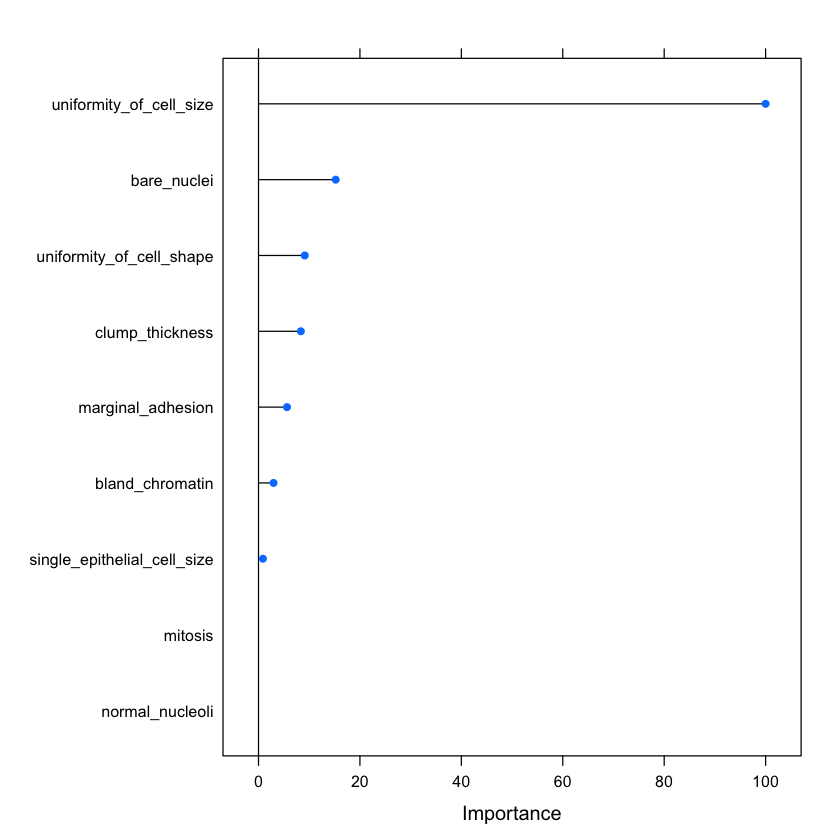

In [39]:
importance <- varImp(model_xgb, scale = TRUE)
plot(importance)

predicting test data

In [40]:
confusionMatrix(predict(model_xgb, test_data), test_data$classes)

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       132         4
  malignant      5        68
                                          
               Accuracy : 0.9569          
                 95% CI : (0.9198, 0.9801)
    No Information Rate : 0.6555          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.905           
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9635          
            Specificity : 0.9444          
         Pos Pred Value : 0.9706          
         Neg Pred Value : 0.9315          
             Prevalence : 0.6555          
         Detection Rate : 0.6316          
   Detection Prevalence : 0.6507          
      Balanced Accuracy : 0.9540          
                                          
       'Positive' Class : benign          
                                          

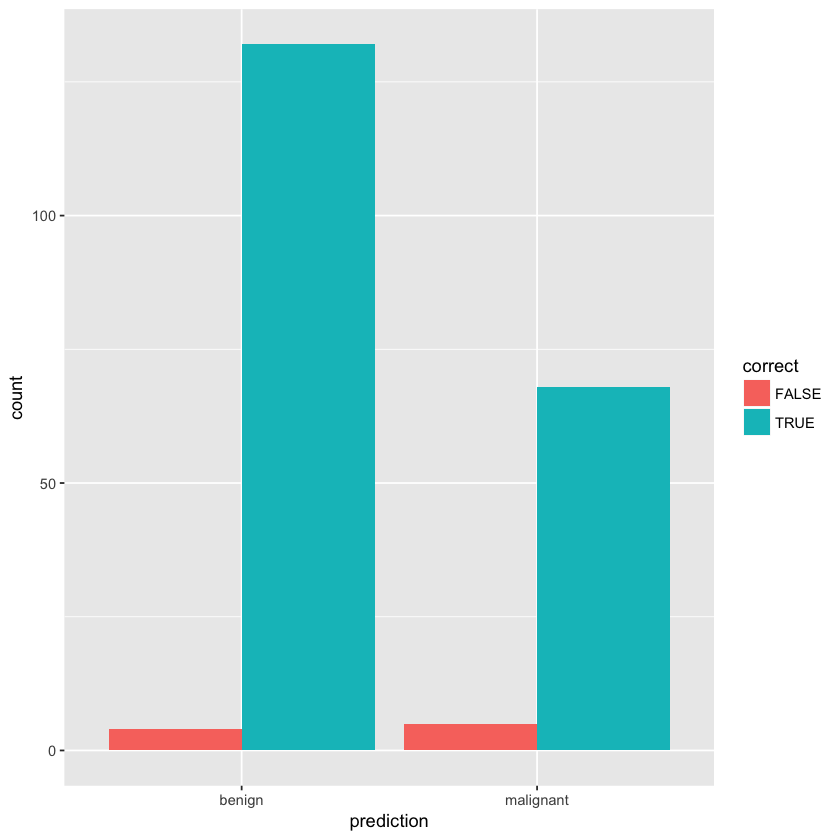

In [41]:
results <- data.frame(actual = test_data$classes,
                      predict(model_xgb, test_data, type = "prob"))

results$prediction <- ifelse(results$benign > 0.5, "benign",
                             ifelse(results$malignant > 0.5, "malignant", NA))

results$correct <- ifelse(results$actual == results$prediction, TRUE, FALSE)

ggplot(results, aes(x = prediction, fill = correct)) +
  geom_bar(position = "dodge")

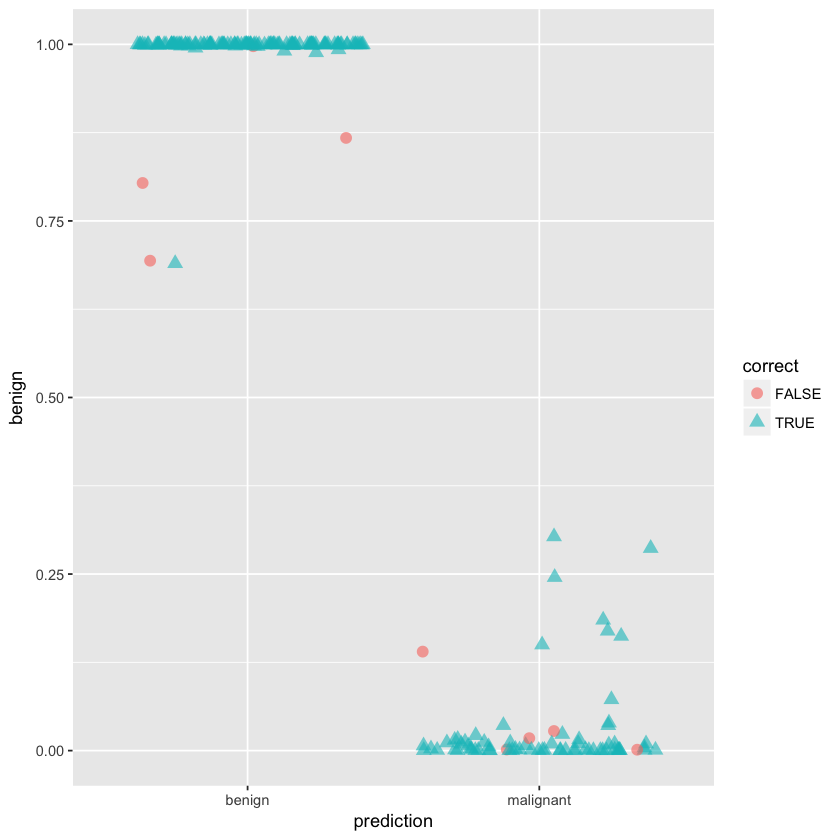

In [42]:
ggplot(results, aes(x = prediction, y = benign, color = correct, shape = correct)) +
  geom_jitter(size = 3, alpha = 0.6)

In [43]:
#install.packages('corrplot')

Feature Selection

Performing feature selection on the whole dataset would lead to prediction bias, we therefore need to run the whole modeling process on the training data alone!

Correlation
Correlations between all features are calculated and visualised with the corrplot package. I am then removing all features with a correlation higher than 0.7, keeping the feature with the lower mean.

corrplot 0.84 loaded


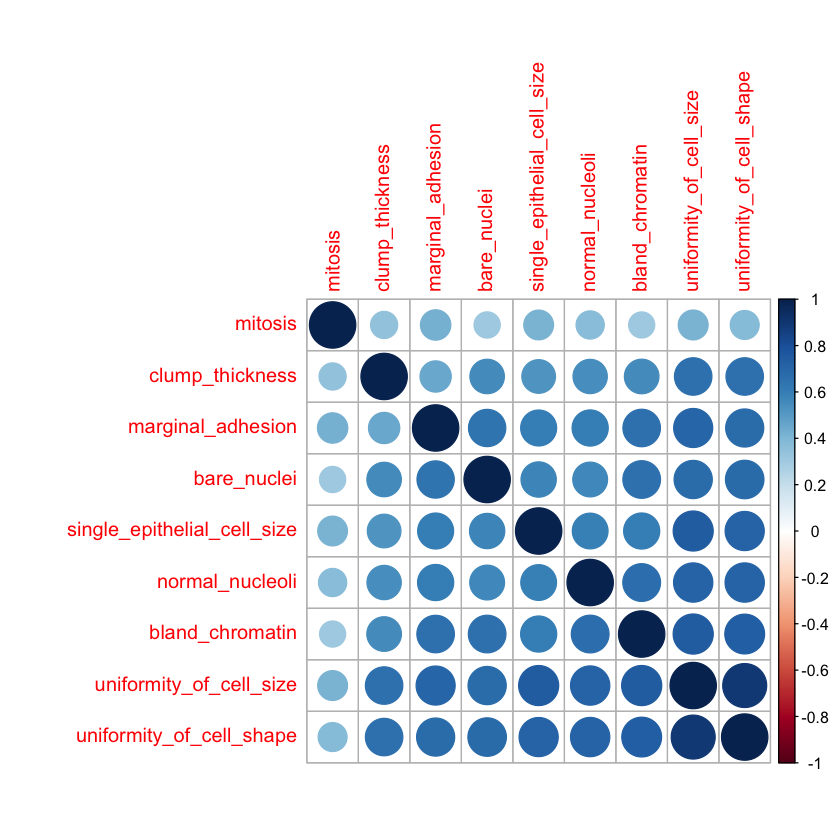

In [44]:
library(corrplot)

# calculate correlation matrix
corMatMy <- cor(train_data[, -1])
corrplot(corMatMy, order = "hclust")

In [45]:
#Apply correlation filter at 0.70,
highlyCor <- colnames(train_data[, -1])[findCorrelation(corMatMy, cutoff = 0.7, verbose = TRUE)]

Compare row 2  and column  3 with corr  0.899 
  Means:  0.696 vs 0.575 so flagging column 2 
Compare row 3  and column  7 with corr  0.736 
  Means:  0.653 vs 0.55 so flagging column 3 
All correlations <= 0.7 


In [46]:
# which variables are flagged for removal?
highlyCor

[1] "uniformity_of_cell_size"  "uniformity_of_cell_shape"

In [47]:
#then we remove these variables
train_data_cor <- train_data[, which(!colnames(train_data) %in% highlyCor)]

Recursive Feature Elimination (RFE)

Another way to choose features is with Recursive Feature Elimination. RFE uses a Random Forest algorithm to test combinations of features and rate each with an accuracy score. The combination with the highest score is usually preferential.

In [48]:
set.seed(7)
results_rfe <- rfe(x = train_data[, -1], 
                   y = train_data$classes, 
                   sizes = c(1:9), 
                   rfeControl = rfeControl(functions = rfFuncs, method = "cv", number = 10))

In [49]:
# chosen features
predictors(results_rfe)

[1] "bare_nuclei"              "uniformity_of_cell_size" 
[3] "clump_thickness"          "uniformity_of_cell_shape"
[5] "bland_chromatin"          "marginal_adhesion"

In [50]:
train_data_rfe <- train_data[, c(1, which(colnames(train_data) %in% predictors(results_rfe)))]

Genetic Algorithm (GA)

The Genetic Algorithm (GA) has been developed based on evolutionary principles of natural selection: It aims to optimize a population of individuals with a given set of genotypes by modeling selection over time. In each generation (i.e. iteration), each individual’s fitness is calculated based on their genotypes. Then, the fittest individuals are chosen to produce the next generation. This subsequent generation of individuals will have genotypes resulting from (re-) combinations of the parental alleles. These new genotypes will again determine each individual’s fitness. This selection process is iterated for a specified number of generations and (ideally) leads to fixation of the fittest alleles in the gene pool.

This concept of optimization can be applied to non-evolutionary models as well, like feature selection processes in machine learning.

In [51]:
set.seed(27)
model_ga <- gafs(x = train_data[, -1], 
                 y = train_data$classes,
                 iters = 10, # generations of algorithm
                 popSize = 10, # population size for each generation
                 levels = c("malignant", "benign"),
                 gafsControl = gafsControl(functions = rfGA, # Assess fitness with RF
                                           method = "cv",    # 10 fold cross validation
                                           genParallel = TRUE, # Use parallel programming
                                           allowParallel = TRUE))

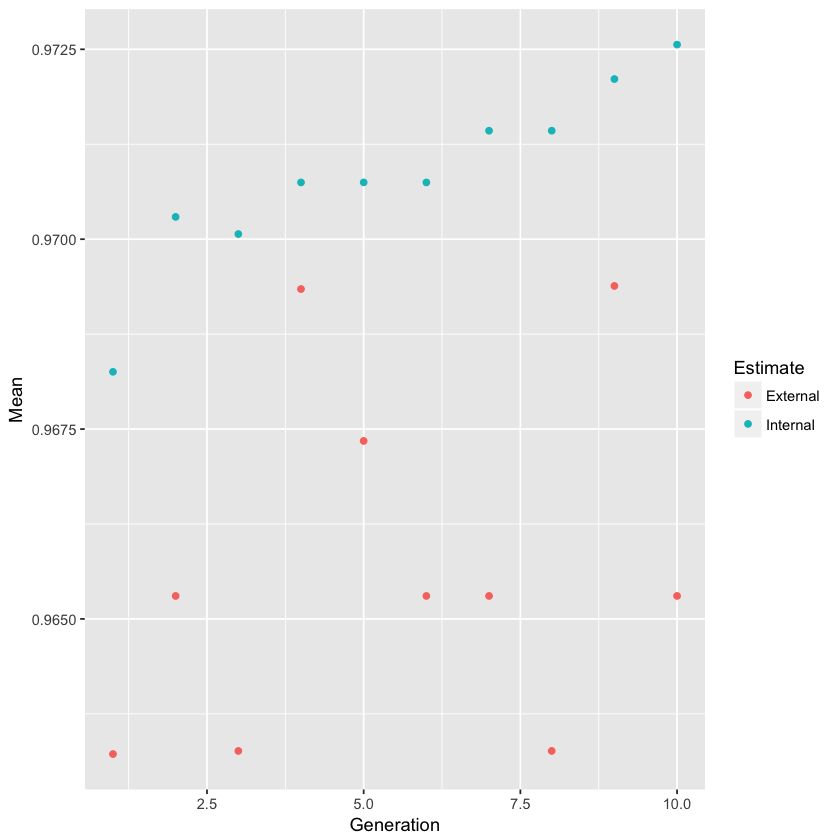

In [52]:
plot(model_ga) # Plot mean fitness (AUC) by generation

In [53]:
train_data_ga <- train_data[, c(1, which(colnames(train_data) %in% model_ga$ga$final))]

Grid search with caret

Automatic Grid

In [54]:
set.seed(42)
model_rf_tune_auto <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE,
                                                  search = "random"),
                         tuneLength = 15)

In [55]:
model_rf_tune_auto

Random Forest 

490 samples
  9 predictor
  2 classes: 'benign', 'malignant' 

Pre-processing: scaled (9), centered (9) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 441, 441, 441, 441, 441, 441, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.9710638  0.9362423
  3     0.9675733  0.9281635
  5     0.9653325  0.9231341
  6     0.9632956  0.9185337
  7     0.9624747  0.9165949
  8     0.9614629  0.9143035
  9     0.9616583  0.9147147

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

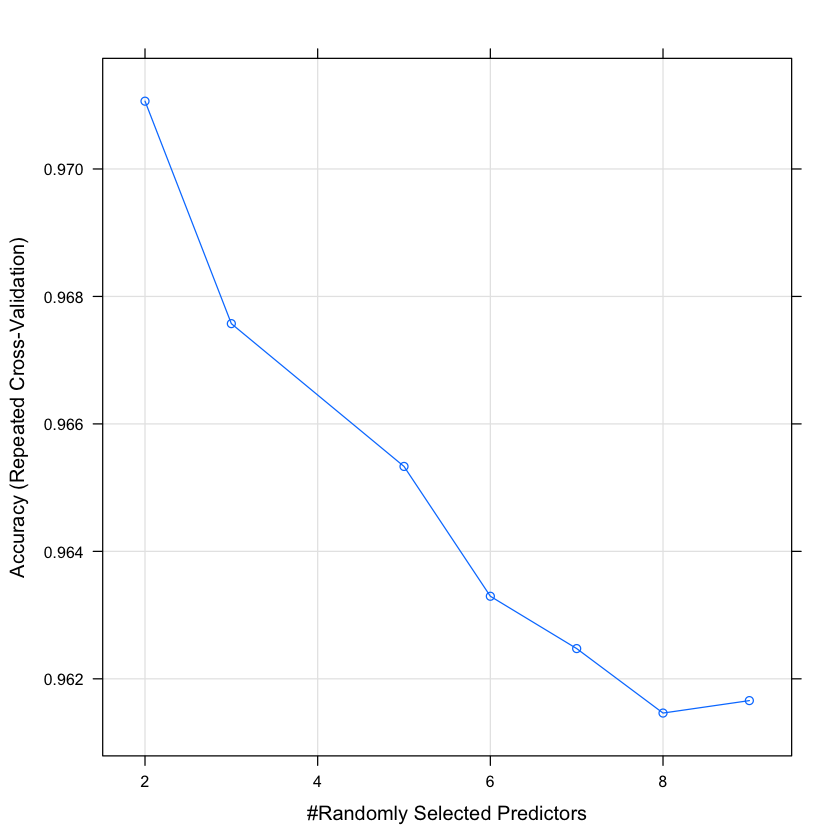

In [56]:
plot(model_rf_tune_auto)

Manual Grid

mtry: Number of variables randomly sampled as candidates at each split.

In [57]:
set.seed(42)
grid <- expand.grid(mtry = c(1:10))

model_rf_tune_man <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE,
                                                  search = "random"),
                         tuneGrid = grid)

In [58]:
model_rf_tune_man

Random Forest 

490 samples
  9 predictor
  2 classes: 'benign', 'malignant' 

Pre-processing: scaled (9), centered (9) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 441, 441, 441, 441, 441, 441, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   1    0.9694228  0.9325085
   2    0.9692226  0.9320790
   3    0.9690061  0.9314195
   4    0.9681896  0.9294927
   5    0.9657531  0.9240577
   6    0.9618709  0.9151847
   7    0.9622748  0.9161726
   8    0.9606379  0.9124587
   9    0.9616711  0.9147268
  10    0.9616626  0.9147502

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 1.

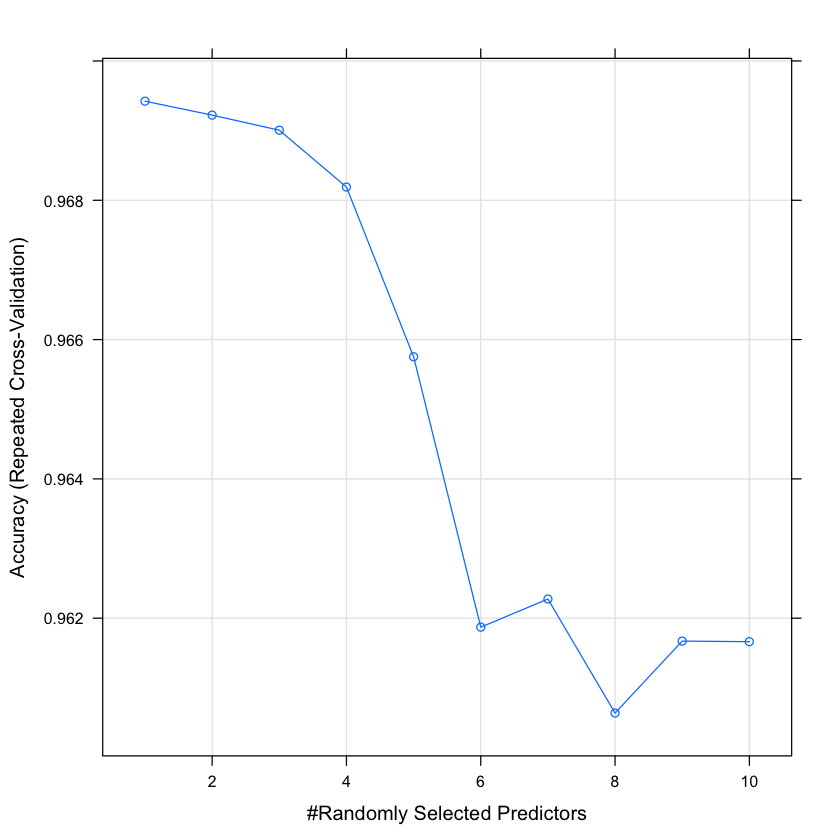

In [59]:
plot(model_rf_tune_man)

In [60]:
#install.packages('h2o')

Grid search with h2o

The R package h2o provides a convenient interface to H2O, which is an open-source machine learning and deep learning platform. H2O distributes a wide range of common machine learning algorithms for classification, regression and deep learning.

In [61]:
library(h2o)
h2o.init(nthreads = -1)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following object is masked from ‘package:Biostrings’:

    %in%

The following objects are masked from ‘package:IRanges’:

    %in%, as.factor, colnames, colnames<-, cor, sd, var

The following objects are masked from ‘package:S4Vectors’:

    %in%, as.factor, colnames, colnames<-, cor, sd, var

The following objects are masked from ‘package:BiocGenerics’:

    colnames, colnames<-, sd, var

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/vw/fy970mhd2czd40pm_413bnpc0000gn/T//Rtmpd0HJYv/h2o_jakewendt_started_from_r.out
    /var/folders/vw/fy970mhd2czd40pm_413bnpc0000gn/T//Rtmpd0HJYv/h2o_jakewendt_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 52 milliseconds 
    H2O cluster version:        3.16.0.2 
    H2O cluster version age:    3 months and 21 days !!! 
    H2O cluster name:           H2O_started_from_R_jakewendt_gyy509 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.56 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         XG

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (3 months and 21 days)!
Please download and install the latest version from http://h2o.ai/download/”

In [62]:
bc_data_hf <- as.h2o(bc_data)

  |======================================================================| 100%


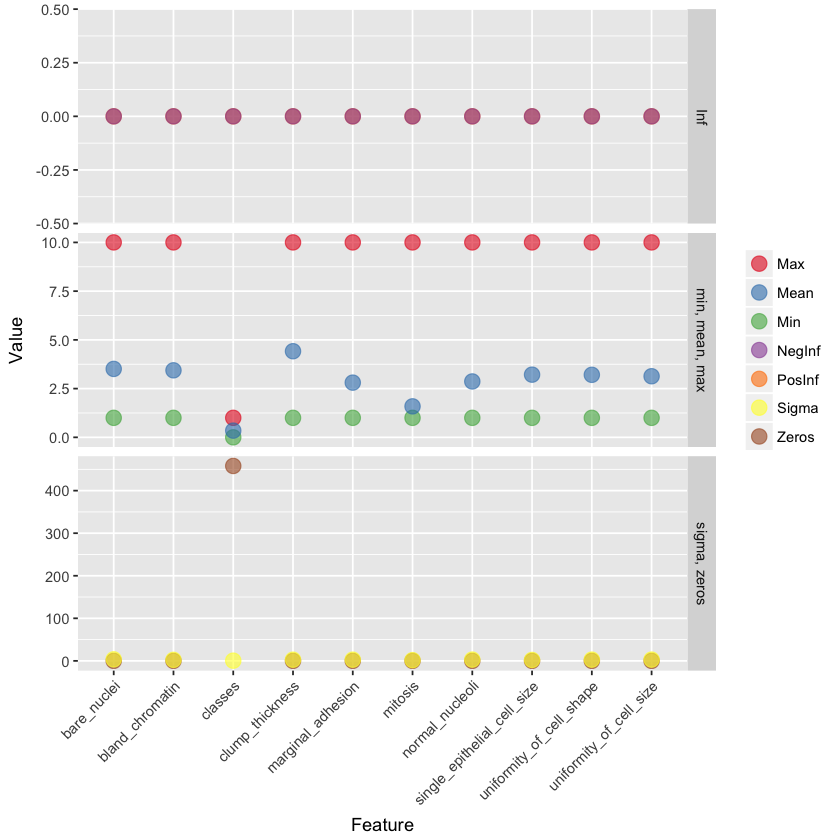

In [63]:
h2o.describe(bc_data_hf) %>%
  gather(x, y, Zeros:Sigma) %>%
  mutate(group = ifelse(x %in% c("Min", "Max", "Mean"), "min, mean, max", 
                        ifelse(x %in% c("NegInf", "PosInf"), "Inf", "sigma, zeros"))) %>% 
  ggplot(aes(x = Label, y = as.numeric(y), color = x)) +
    geom_point(size = 4, alpha = 0.6) +
    scale_color_brewer(palette = "Set1") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
    facet_grid(group ~ ., scales = "free") +
    labs(x = "Feature",
         y = "Value",
         color = "")


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

No id variables; using all as measure variables


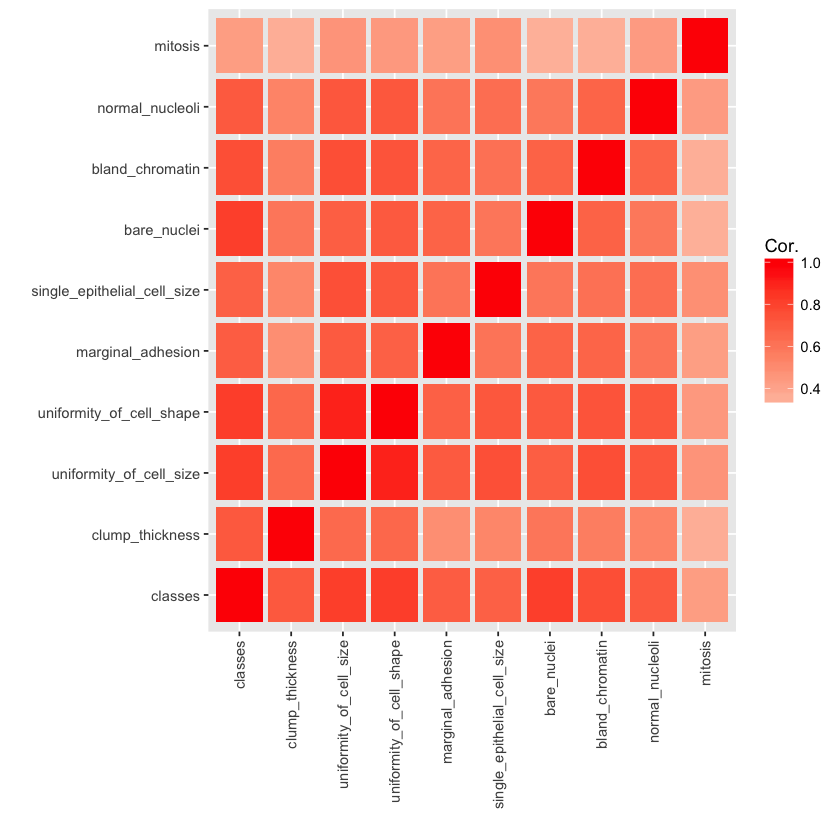

In [64]:
library(reshape2) # for melting

bc_data_hf[, 1] <- h2o.asfactor(bc_data_hf[, 1])

cor <- h2o.cor(bc_data_hf)
rownames(cor) <- colnames(cor)

melt(cor) %>%
  mutate(Var2 = rep(rownames(cor), nrow(cor))) %>%
  mutate(Var2 = factor(Var2, levels = colnames(cor))) %>%
  mutate(variable = factor(variable, levels = colnames(cor))) %>%
  ggplot(aes(x = variable, y = Var2, fill = value)) + 
    geom_tile(width = 0.9, height = 0.9) +
    scale_fill_gradient2(low = "white", high = "red", name = "Cor.") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    labs(x = "", 
         y = "")

Training, validation and test data

In [65]:
splits <- h2o.splitFrame(bc_data_hf, 
                         ratios = c(0.7, 0.15), 
                         seed = 1)

train <- splits[[1]]
valid <- splits[[2]]
test <- splits[[3]]

response <- "classes"
features <- setdiff(colnames(train), response)

In [66]:
summary(train$classes, exact_quantiles = TRUE)

 classes       
 benign   :317 
 malignant:174 

In [67]:
summary(valid$classes, exact_quantiles = TRUE)

 classes      
 benign   :71 
 malignant:35 

In [68]:
summary(test$classes, exact_quantiles = TRUE)

 classes      
 benign   :70 
 malignant:32 

In [69]:
pca <- h2o.prcomp(training_frame = train,
           x = features,
           validation_frame = valid,
           transform = "NORMALIZE",
           impute_missing = TRUE,
           k = 3,
           seed = 42)

  |======================================================================| 100%


In [70]:
#install.packages('ggrepel')

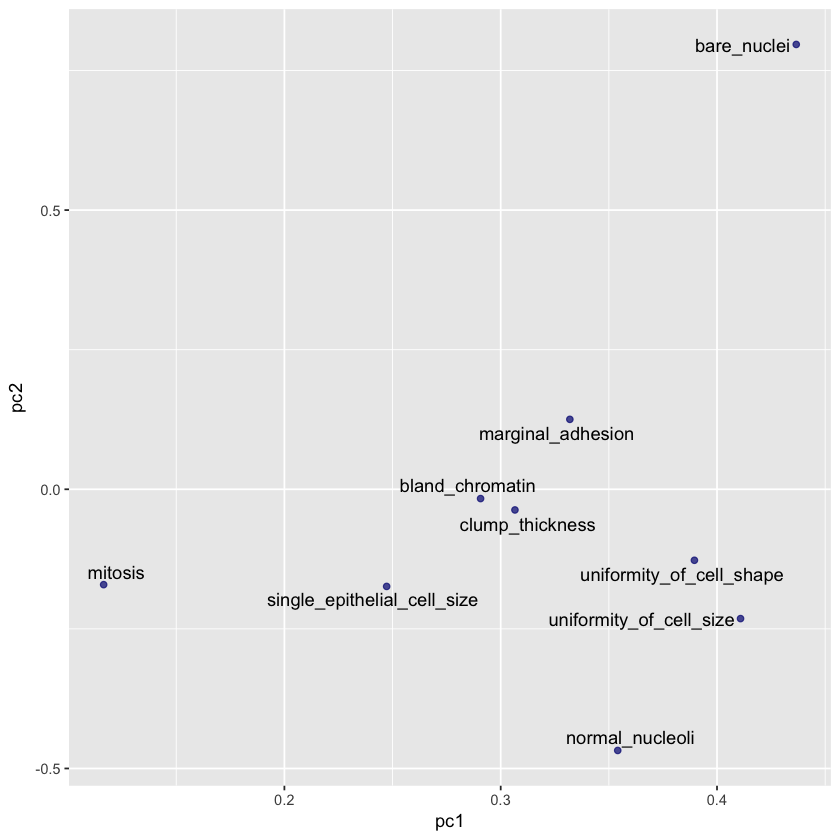

In [71]:
eigenvec <- as.data.frame(pca@model$eigenvectors)
eigenvec$label <- features

library(ggrepel)
ggplot(eigenvec, aes(x = pc1, y = pc2, label = label)) +
  geom_point(color = "navy", alpha = 0.7) +
  geom_text_repel()

Classification

Random Forest

In [72]:
hyper_params <- list(
                     ntrees = c(25, 50, 75, 100),
                     max_depth = c(10, 20, 30),
                     min_rows = c(1, 3, 5)
                     )

search_criteria <- list(
                        strategy = "RandomDiscrete", 
                        max_models = 50,
                        max_runtime_secs = 360,
                        stopping_rounds = 5,          
                        stopping_metric = "AUC",      
                        stopping_tolerance = 0.0005,
                        seed = 42
                        )

In [73]:
rf_grid <- h2o.grid(algorithm = "randomForest", # h2o.randomForest, 
                                                # alternatively h2o.gbm 
                                                # for Gradient boosting trees
                    x = features,
                    y = response,
                    grid_id = "rf_grid",
                    training_frame = train,
                    validation_frame = valid,
                    nfolds = 25,                           
                    fold_assignment = "Stratified",
                    hyper_params = hyper_params,
                    search_criteria = search_criteria,
                    seed = 42
                    )

  |======================================================================| 100%


In [74]:
# performance metrics where smaller is better -> order with decreasing = FALSE
sort_options_1 <- c("mean_per_class_error", "mse", "err", "logloss")

for (sort_by_1 in sort_options_1) {
  
  grid <- h2o.getGrid("rf_grid", sort_by = sort_by_1, decreasing = FALSE)
  
  model_ids <- grid@model_ids
  best_model <- h2o.getModel(model_ids[[1]])
  
  h2o.saveModel(best_model, path="models", force = TRUE)
  
}


# performance metrics where bigger is better -> order with decreasing = TRUE
sort_options_2 <- c("auc", "precision", "accuracy", "recall", "specificity")

for (sort_by_2 in sort_options_2) {
  
  grid <- h2o.getGrid("rf_grid", sort_by = sort_by_2, decreasing = TRUE)
  
  model_ids <- grid@model_ids
  best_model <- h2o.getModel(model_ids[[1]])
  
  h2o.saveModel(best_model, path = "models", force = TRUE)
  
}

In [75]:
files <- list.files(path = "models")

In [76]:
files

[1] "rf_grid_model_10" "rf_grid_model_14" "rf_grid_model_16" "rf_grid_model_17"
 [5] "rf_grid_model_19" "rf_grid_model_2"  "rf_grid_model_20" "rf_grid_model_22"
 [9] "rf_grid_model_24" "rf_grid_model_25" "rf_grid_model_26" "rf_grid_model_28"
[13] "rf_grid_model_30" "rf_grid_model_35" "rf_grid_model_4"

In [77]:
rf_models <- files[grep("rf_grid_model", files)]

In [78]:
rf_models

[1] "rf_grid_model_10" "rf_grid_model_14" "rf_grid_model_16" "rf_grid_model_17"
 [5] "rf_grid_model_19" "rf_grid_model_2"  "rf_grid_model_20" "rf_grid_model_22"
 [9] "rf_grid_model_24" "rf_grid_model_25" "rf_grid_model_26" "rf_grid_model_28"
[13] "rf_grid_model_30" "rf_grid_model_35" "rf_grid_model_4"

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set1 is 9
Returning the palette you asked for with that many colors
”

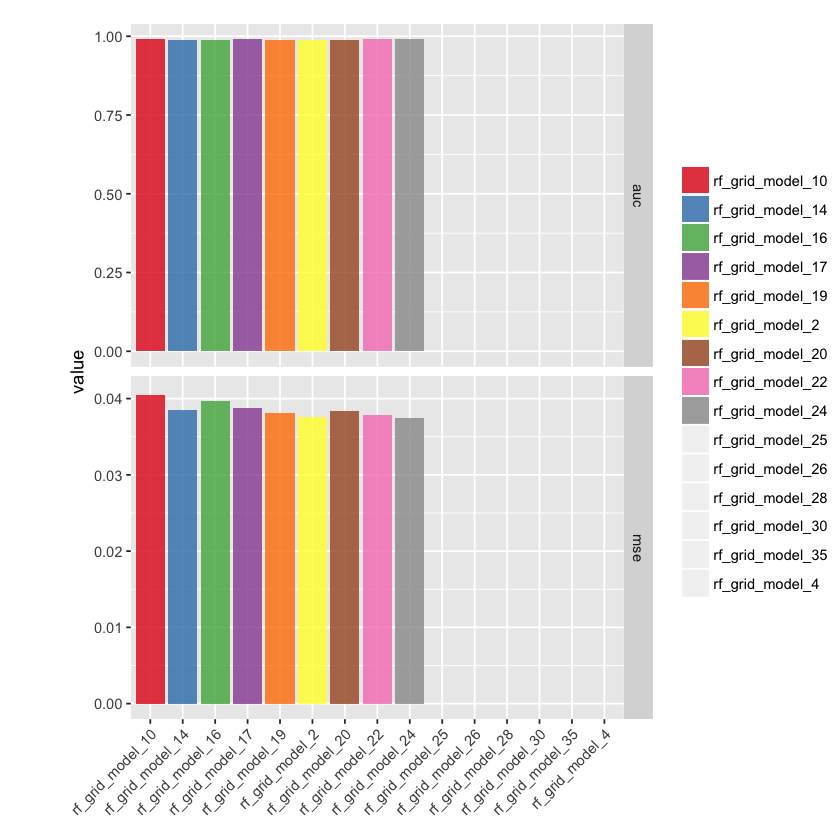

In [79]:
for (model_id in rf_models) {
#  path <- paste0("U:\\Github_blog\\Webinar\\Webinar_ML_for_disease\\models\\", model_id)

  path <- paste0(getwd(),"/models/", model_id)
  best_model <- h2o.loadModel(path)

  mse_auc_test <- data.frame(model_id = model_id, 
                             mse = h2o.mse(h2o.performance(best_model, test)),
                             auc = h2o.auc(h2o.performance(best_model, test)))
  
  if (model_id == rf_models[[1]]) {
    
    mse_auc_test_comb <- mse_auc_test
    
  } else {
    
    mse_auc_test_comb <- rbind(mse_auc_test_comb, mse_auc_test)
    
  }
}

mse_auc_test_comb %>%
  gather(x, y, mse:auc) %>%
  ggplot(aes(x = model_id, y = y, fill = model_id)) +
    facet_grid(x ~ ., scales = "free") +
    geom_bar(stat = "identity", alpha = 0.8, position = "dodge") +
    scale_fill_brewer(palette = "Set1") +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1),
          plot.margin = unit(c(0.5, 0, 0, 1.5), "cm")) +
    labs(x = "", y = "value", fill = "")

In [80]:
for (model_id in rf_models) {
  
  best_model <- h2o.getModel(model_id)
  
  finalRf_predictions <- data.frame(model_id = rep(best_model@model_id, 
                                                   nrow(test)),
                                    actual = as.vector(test$classes), 
                                    as.data.frame(h2o.predict(object = best_model, 
                                                              newdata = test)))
  
  finalRf_predictions$accurate <- ifelse(finalRf_predictions$actual == 
                                           finalRf_predictions$predict, 
                                         "yes", "no")
  
  finalRf_predictions$predict_stringent <- ifelse(finalRf_predictions$benign > 0.8, 
                                                  "benign", 
                                                  ifelse(finalRf_predictions$malignant 
                                                         > 0.8, "malignant", "uncertain"))
  
  finalRf_predictions$accurate_stringent <- ifelse(finalRf_predictions$actual == 
                                                     finalRf_predictions$predict_stringent, "yes", 
                                         ifelse(finalRf_predictions$predict_stringent == 
                                                  "uncertain", "na", "no"))
  
  if (model_id == rf_models[[1]]) {
    
    finalRf_predictions_comb <- finalRf_predictions
    
  } else {
    
    finalRf_predictions_comb <- rbind(finalRf_predictions_comb, finalRf_predictions)
    
  }
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

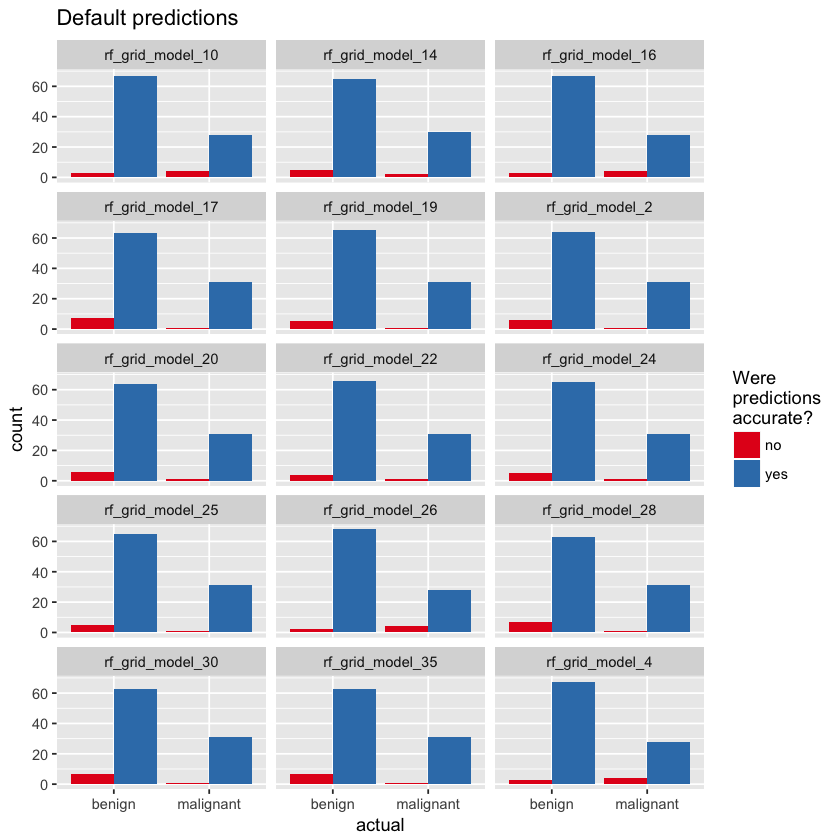

In [81]:
finalRf_predictions_comb %>%
  ggplot(aes(x = actual, fill = accurate)) +
    geom_bar(position = "dodge") +
    scale_fill_brewer(palette = "Set1") +
    facet_wrap(~ model_id, ncol = 3) +
    labs(fill = "Were\npredictions\naccurate?",
         title = "Default predictions")

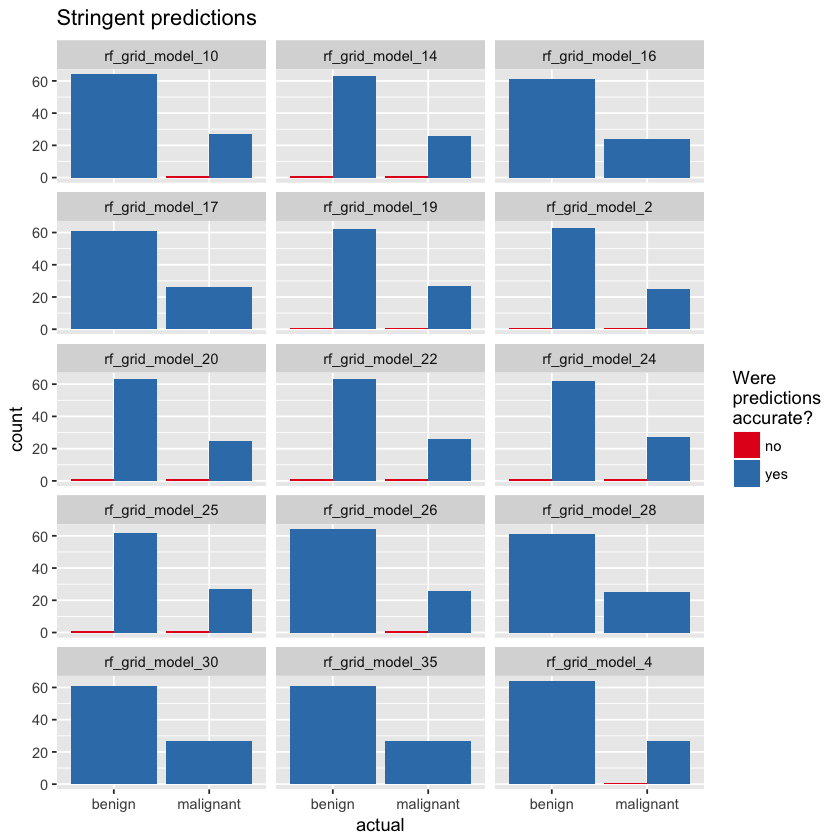

In [82]:
finalRf_predictions_comb %>%
  subset(accurate_stringent != "na") %>%
  ggplot(aes(x = actual, fill = accurate_stringent)) +
    geom_bar(position = "dodge") +
    scale_fill_brewer(palette = "Set1") +
    facet_wrap(~ model_id, ncol = 3) +
    labs(fill = "Were\npredictions\naccurate?",
         title = "Stringent predictions")

In [83]:
#rf_model <- h2o.loadModel("models/rf_grid_model_6")
rf_model <- h2o.loadModel("models/rf_grid_model_35")

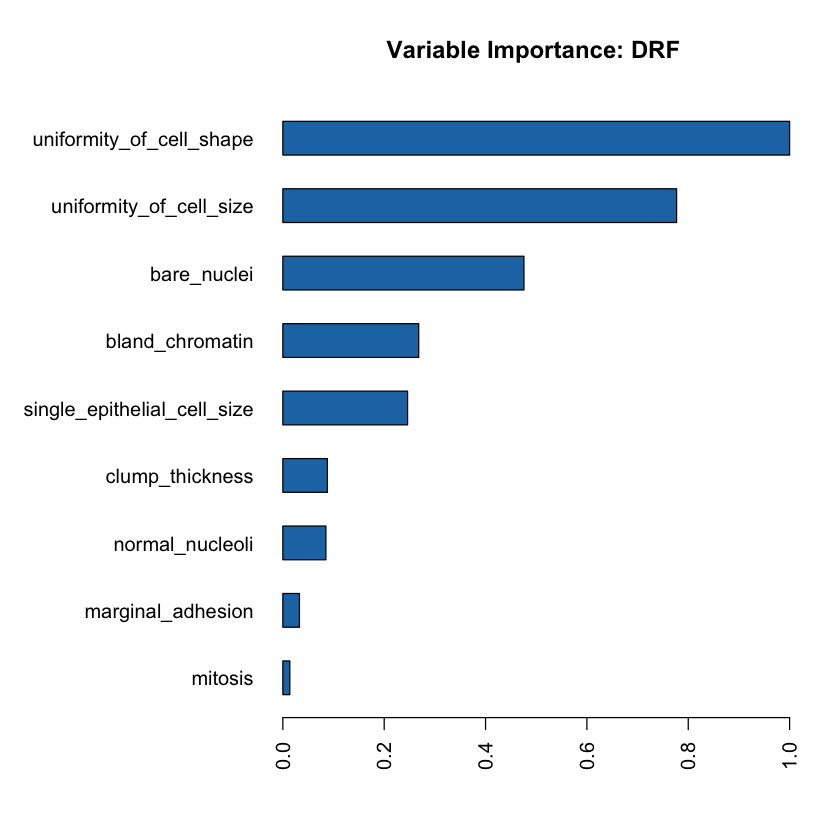

In [84]:
h2o.varimp_plot(rf_model)

In [85]:
h2o.varimp(rf_model)

variable,relative_importance,scaled_importance,percentage
uniformity_of_cell_shape,3118.89575,1.00000000,0.334852017
uniformity_of_cell_size,2423.43481,0.77701693,0.260185687
bare_nuclei,1483.88000,0.47577095,0.159312863
bland_chromatin,836.15686,0.26809388,0.089771776
single_epithelial_cell_size,767.66351,0.24613311,0.082418168
clump_thickness,274.21054,0.08791911,0.029439892
normal_nucleoli,265.03363,0.08497675,0.028454637
marginal_adhesion,102.12691,0.03274457,0.010964587
mitosis,42.84903,0.01373853,0.004600373


In [86]:
h2o.mean_per_class_error(rf_model, train = TRUE, valid = TRUE, xval = TRUE)

train       valid        xval 
0.025970847 0.007042254 0.024674571

In [87]:
h2o.confusionMatrix(rf_model, valid = TRUE)

,benign,malignant,Error,Rate
benign,70,1,0.014084507,=1/71
malignant,0,35,0.000000000,=0/35
Totals,70,36,0.009433962,=1/106


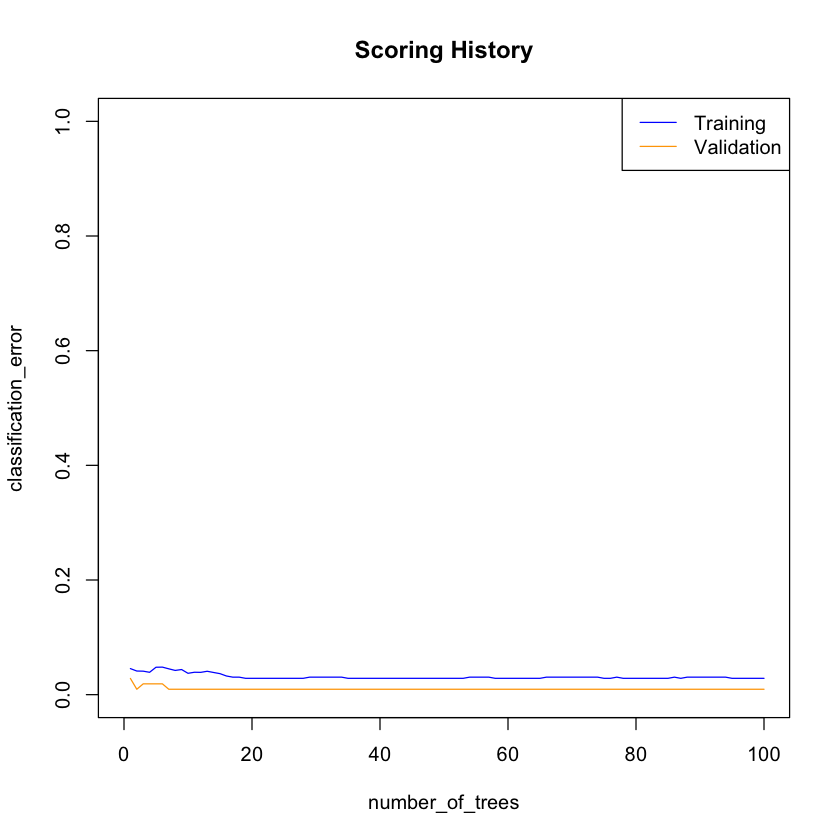

In [88]:
plot(rf_model,
     timestep = "number_of_trees",
     metric = "classification_error")

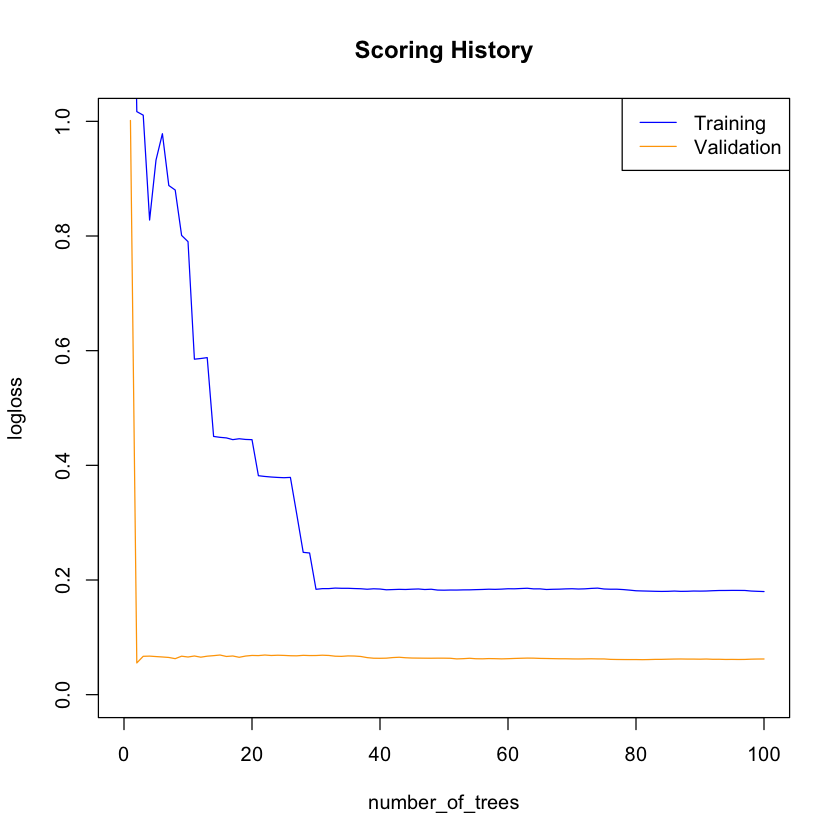

In [89]:
plot(rf_model,
     timestep = "number_of_trees",
     metric = "logloss")

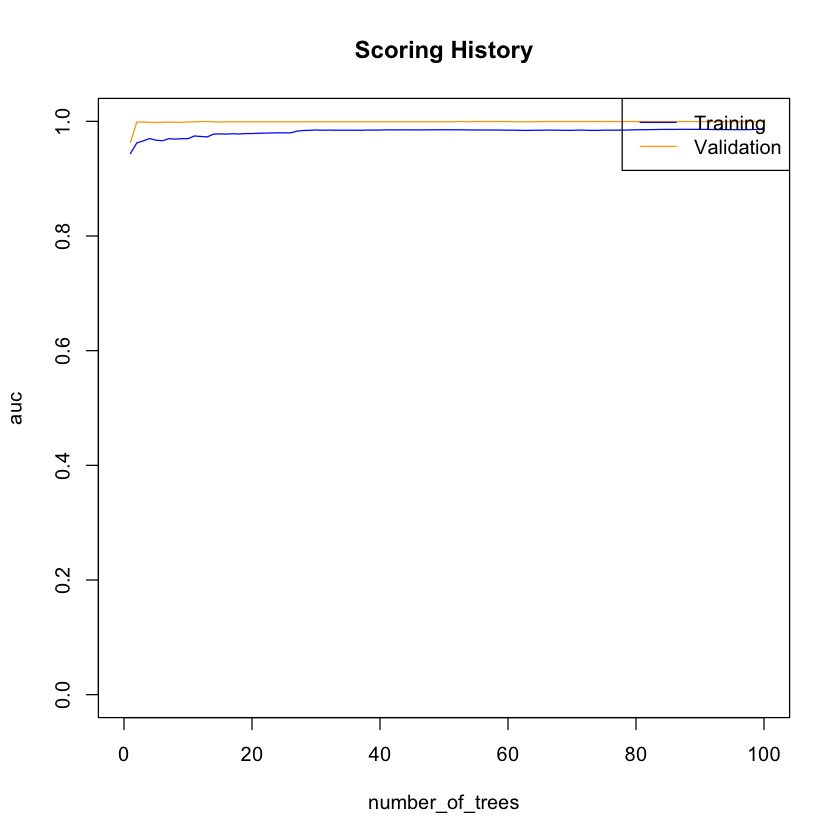

In [90]:
plot(rf_model,
     timestep = "number_of_trees",
     metric = "AUC")

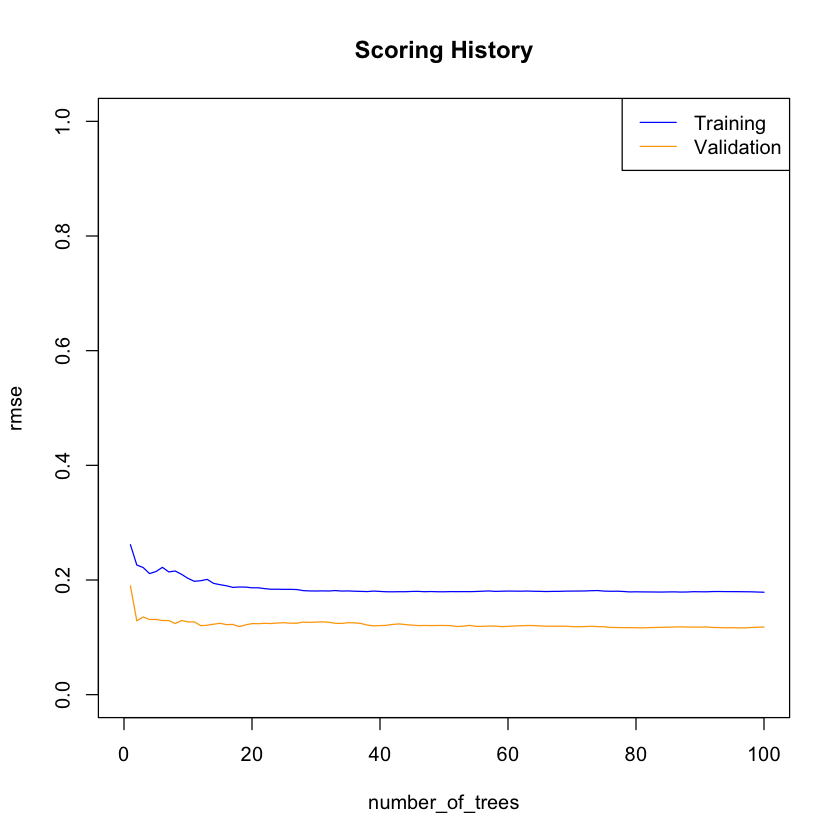

In [91]:
plot(rf_model,
     timestep = "number_of_trees",
     metric = "rmse")

In [92]:
h2o.auc(rf_model, train = TRUE)

[1] 0.9857954

In [93]:
h2o.auc(rf_model, valid = TRUE)

[1] 0.9995976

In [94]:
h2o.auc(rf_model, xval = TRUE)

[1] 0.9876718

In [95]:
perf <- h2o.performance(rf_model, test)
perf

H2OBinomialMetrics: drf

MSE:  0.03859933
RMSE:  0.1964671
LogLoss:  0.120039
Mean Per-Class Error:  0.06964286
AUC:  0.990625
Gini:  0.98125

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
          benign malignant    Error    Rate
benign        69         1 0.014286   =1/70
malignant      4        28 0.125000   =4/32
Totals        73        29 0.049020  =5/102

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.764167 0.918033  25
2                       max f2  0.241333 0.952381  35
3                 max f0point5  0.826833 0.964286  23
4                 max accuracy  0.826833 0.950980  23
5                max precision  1.000000 1.000000   0
6                   max recall  0.241333 1.000000  35
7              max specificity  1.000000 1.000000   0
8             max absolute_mcc  0.826833 0.887412  23
9   max min_per_class_accuracy  0.450333 0.937500

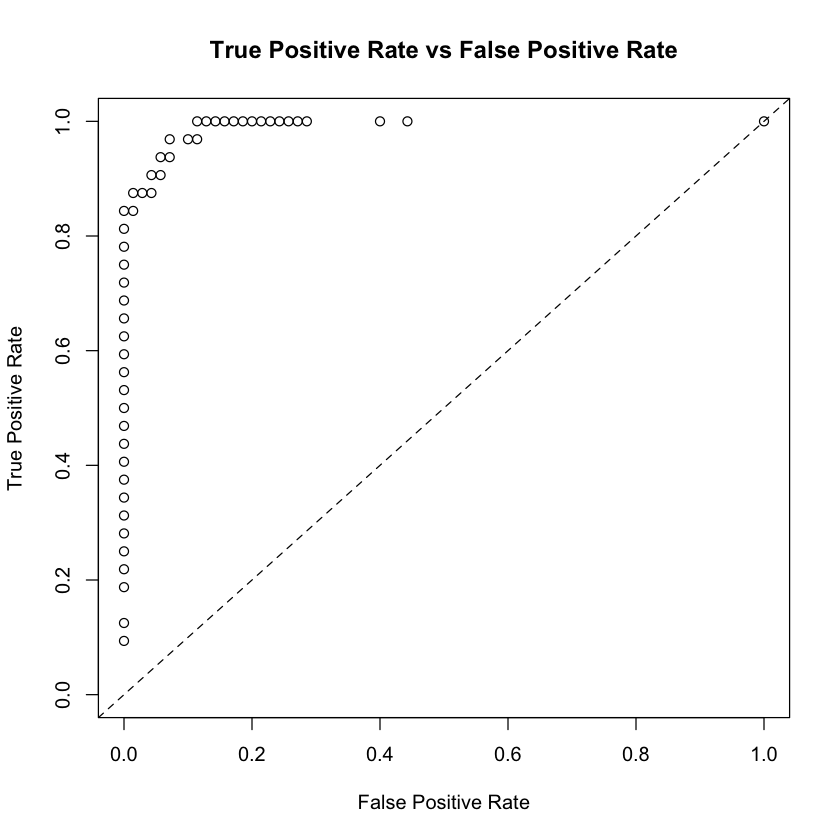

In [96]:
plot(perf)

In [97]:
h2o.logloss(perf)

[1] 0.120039

In [98]:
h2o.mse(perf)

[1] 0.03859933

In [99]:
h2o.auc(perf)

[1] 0.990625

In [100]:
head(h2o.metric(perf))

threshold,f1,f2,f0point5,accuracy,precision,recall,specificity,absolute_mcc,min_per_class_accuracy,mean_per_class_accuracy,tns,fns,fps,tps,tnr,fnr,fpr,tpr,idx
1.0000000,0.1714286,0.1145038,0.3409091,0.7156863,1,0.09375,1,0.2574643,0.09375,0.546875,70,29,0,3,1,0.90625,0,0.09375,0
0.9975000,0.2222222,0.1515152,0.4166667,0.7254902,1,0.12500,1,0.2988072,0.12500,0.562500,70,28,0,4,1,0.87500,0,0.12500,1
0.9966667,0.3157895,0.2238806,0.5357143,0.7450980,1,0.18750,1,0.3697550,0.18750,0.593750,70,26,0,6,1,0.81250,0,0.18750,2
0.9960000,0.3589744,0.2592593,0.5833333,0.7549020,1,0.21875,1,0.4014775,0.21875,0.609375,70,25,0,7,1,0.78125,0,0.21875,3
0.9900000,0.4000000,0.2941176,0.6250000,0.7647059,1,0.25000,1,0.4314745,0.25000,0.625000,70,24,0,8,1,0.75000,0,0.25000,4
0.9893333,0.4390244,0.3284672,0.6617647,0.7745098,1,0.28125,1,0.4601017,0.28125,0.640625,70,23,0,9,1,0.71875,0,0.28125,5


In [101]:
finalRf_predictions <- data.frame(actual = as.vector(test$classes), 
                                  as.data.frame(h2o.predict(object = rf_model, 
                                                            newdata = test)))

  |======================================================================| 100%


In [102]:
finalRf_predictions$accurate <- ifelse(finalRf_predictions$actual == 
                                         finalRf_predictions$predict, "yes", "no")

finalRf_predictions$predict_stringent <- ifelse(finalRf_predictions$benign > 0.8, "benign", 
                                                ifelse(finalRf_predictions$malignant 
                                                       > 0.8, "malignant", "uncertain"))
finalRf_predictions$accurate_stringent <- ifelse(finalRf_predictions$actual == 
                                                   finalRf_predictions$predict_stringent, "yes", 
                                       ifelse(finalRf_predictions$predict_stringent == 
                                                "uncertain", "na", "no"))

finalRf_predictions %>%
  group_by(actual, predict) %>%
  dplyr::summarise(n = n())

actual,predict,n
benign,benign,63
benign,malignant,7
malignant,benign,1
malignant,malignant,31


In [103]:
finalRf_predictions %>%
  group_by(actual, predict_stringent) %>%
  dplyr::summarise(n = n())

actual,predict_stringent,n
benign,benign,61
benign,uncertain,9
malignant,malignant,27
malignant,uncertain,5


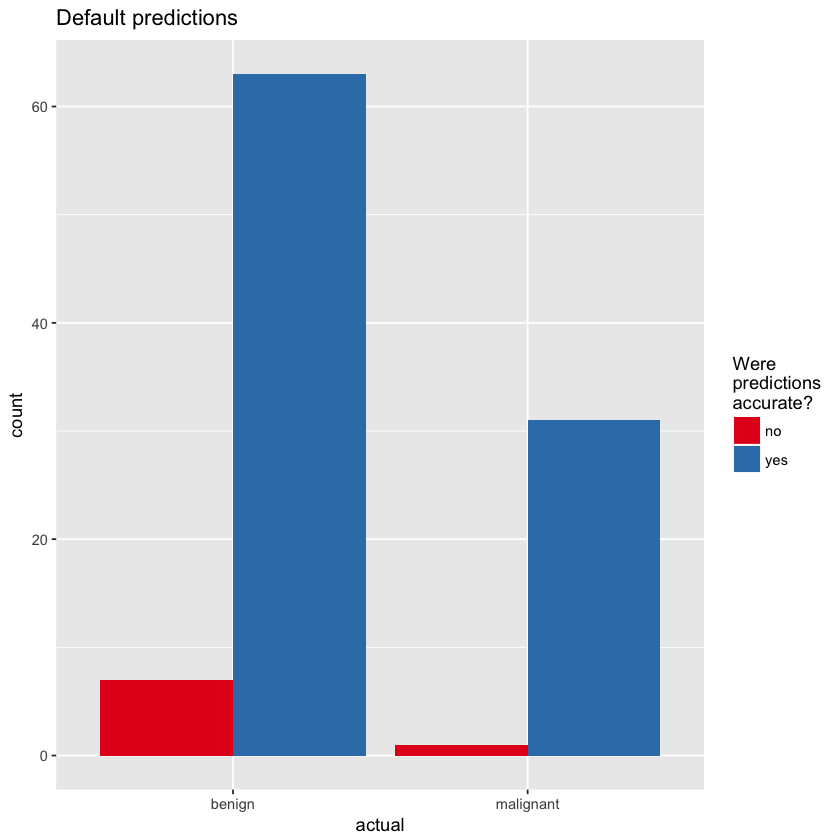

In [104]:
finalRf_predictions %>%
  ggplot(aes(x = actual, fill = accurate)) +
    geom_bar(position = "dodge") +
    scale_fill_brewer(palette = "Set1") +
    labs(fill = "Were\npredictions\naccurate?",
         title = "Default predictions")

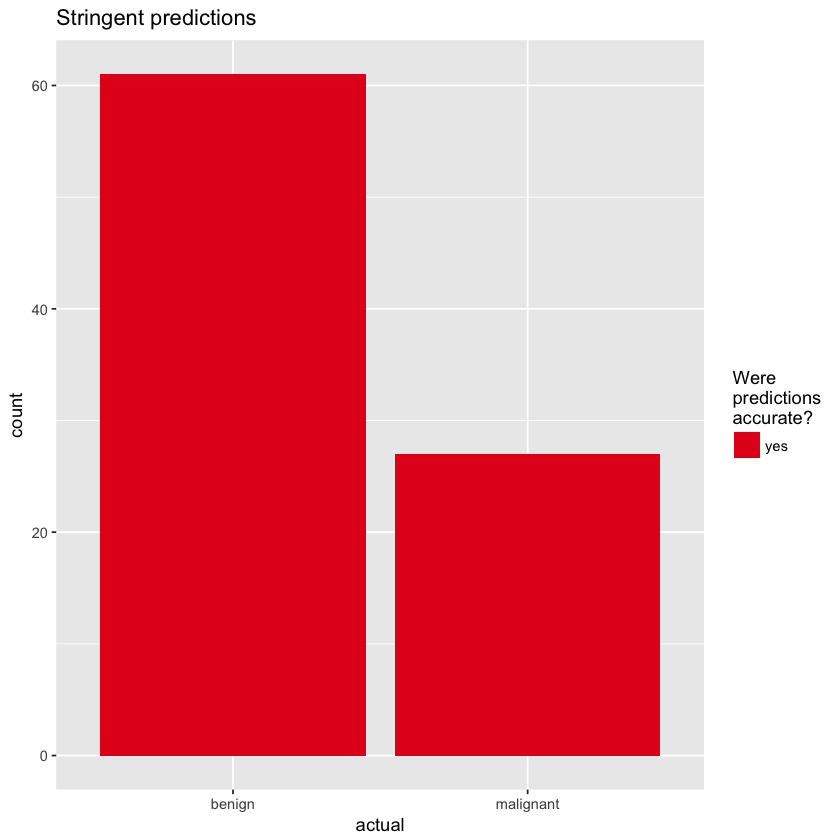

In [105]:
finalRf_predictions %>%
  subset(accurate_stringent != "na") %>%
  ggplot(aes(x = actual, fill = accurate_stringent)) +
    geom_bar(position = "dodge") +
    scale_fill_brewer(palette = "Set1") +
    labs(fill = "Were\npredictions\naccurate?",
         title = "Stringent predictions")

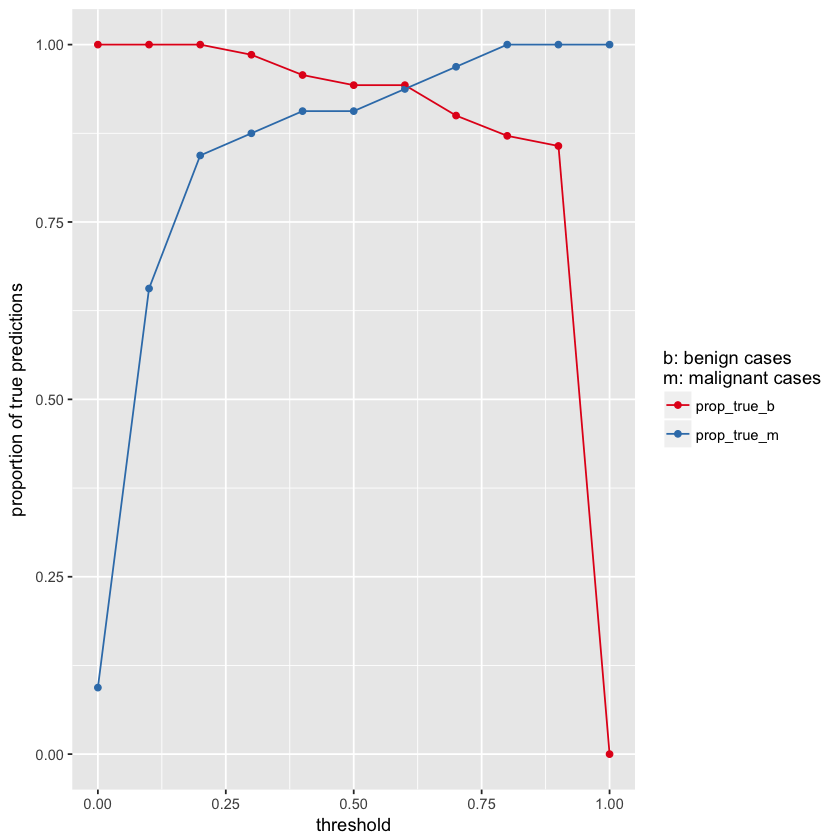

In [106]:
df <- finalRf_predictions[, c(1, 3, 4)]

thresholds <- seq(from = 0, to = 1, by = 0.1)

prop_table <- data.frame(threshold = thresholds, prop_true_b = NA, prop_true_m = NA)

for (threshold in thresholds) {
  pred <- ifelse(df$benign > threshold, "benign", "malignant")
  pred_t <- ifelse(pred == df$actual, TRUE, FALSE)
  
  group <- data.frame(df, "pred" = pred_t) %>%
  group_by(actual, pred) %>%
  dplyr::summarise(n = n())
  
  group_b <- filter(group, actual == "benign")
  
  prop_b <- sum(filter(group_b, pred == TRUE)$n) / sum(group_b$n)
  prop_table[prop_table$threshold == threshold, "prop_true_b"] <- prop_b
  
  group_m <- filter(group, actual == "malignant")
  
  prop_m <- sum(filter(group_m, pred == TRUE)$n) / sum(group_m$n)
  prop_table[prop_table$threshold == threshold, "prop_true_m"] <- prop_m
}

prop_table %>%
  gather(x, y, prop_true_b:prop_true_m) %>%
  ggplot(aes(x = threshold, y = y, color = x)) +
    geom_point() +
    geom_line() +
    scale_color_brewer(palette = "Set1") +
    labs(y = "proportion of true predictions",
         color = "b: benign cases\nm: malignant cases")

In [107]:
h2o.shutdown(prompt=FALSE)

[1] TRUE

In [108]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-apple-darwin17.3.0 (64-bit)
Running under: macOS High Sierra 10.13.3

Matrix products: default
BLAS: /opt/local/Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRblas.dylib
LAPACK: /opt/local/Library/Frameworks/R.framework/Versions/3.4/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggrepel_0.7.0        reshape2_1.4.3       bindrcpp_0.2        
 [4] h2o_3.16.0.2         corrplot_0.84        rpart.plot_2.1.2    
 [7] rpart_4.1-13         dplyr_0.7.4          caret_6.0-78        
[10] doParallel_1.0.11    iterators_1.0.9      foreach_1.4.4       
[13] tidyr_0.8.0          pcaGoPromoter_1.22.0 Biostrings_2.46.0   
[16] XVector_0.18.0       IRanges_2.12.0       S4Vectors_0.16.0    
[19] BiocGenerics_0.24.0  ellipse_0.4.1    